# First-Year Writing Seminars: Extension

**Objectives:**
* Formulate a new approach to the FWS assignment problem using ideas from min-cost flow.
* Improve an existing model by adding new constraints and nuances.
* Get comfortable with ORTools syntax.

**Key Ideas:**
* integrality property
* the min-cost flow problem
* the transportation problem
* the assignment problem

**Reading Assignment:**
* Read Handout 7.5 on the min-cost flow problem.

**Brief description:** If you recall pre-enroll, there was a separate ballot you completed by listing your top 5 picks for FWS that semester. You were later notified which class you got placed into, probably hoping it was your first choice. By now, this should not seem like magic; problems like these often enlist help from Operations Research especially as the scale increases. Disclaimer: the following models are not actually used by Cornell.

In [1]:
# imports -- don't forget to run this cell!
import numpy as np
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR
from ortools.graph import pywrapgraph as ORMC
from networkx.algorithms.flow import min_cost_flow

# Part 1: Min-Cost Flow Formulation

**Review** 

Recall the min-cost flow problem. It takes as input
* A directed graph $G = (V,A)$,
* costs $c(i,j)$ for shipping one unit of good from node $i$ to node $j$ for each arc $(i,j) \in A$,
* capacities $u(i,j)$ for each arc $(i,j) \in A$,
* supply values $b(i)$ for each node $i \in V$, such that $\sum_{i \in V} b(i) = 0$.

Remember also that at each node $i$, our supply value $b(i)$ is greater than 0 if there is supply at node $i$, less than 0 if there is demand at node $i$, and equal to 0 if there is neither supply nor demand at node $i$ (i.e., node $i$ is a transit node). Using shortest-path terminology, supply nodes are "sources," demand nodes are "sinks," and transit nodes are interior nodes.

Our goal is to find a feasible flow that satisfies both flow-capacity constraints and flow-conservation constraints; that is, we wish to find a flow $f(i,j)$ on all arcs such that $0 \leq f(i,j) \leq u(i,j)$ for every arc $(i,j) \in A$ and $\sum_{(i,j) \in A} f(i,j) - \sum_{(j,i) \in A} f(j,i) = b(i)$ for every node $i \in V$.

The objective value of a feasible solution is given by $\sum_{(i,j) \in A} c(i,j)*f(i,j)$. We'd like to minimize this cost function&mdash;in other words, find a "min-cost" flow.

(For a more in-depth discussion, see Handout 7.5 and the min-cost flow lab.)

**Formulating the model**

In Handout 7.5, we learned that the transportation problem is really just a specific case of the min-cost flow problem. Let's use this fact, along with the transportation model we've already created in the FWS lab, to formulate a min-cost flow model.

Nodes for each student and class section, as well as the special 'dummy' supply node, remain the same as before, as do our arcs and edge costs; all we need to do to create a min-cost flow input is define (1) the arc capacities and (2) the supply values at each node, and we'll be all set!

**Q1:** What should the capacity $u(i,j)$ on each arc $(i,j)$ be? (An arc $(i,j)$ connects a student node $i$ to a class node $j$.)

**A:** <font color='blue'>1</font>

**Q2:** We also need to define the capacity $u(dummy,j)$ on each arc leaving the 'dummy' node to a class node. We could set it to infinity, since there are an infinite number of "dummy students" we could assign to each class. Can you find a better upper bound? (Hint: we cannot have more than 16 students in a class)

**A:** <font color='blue'> Yes; set $u(dummy,j) = 16$. More generally, we set $u(dummy,j) = $ (max number of 'real' students) $ - $ (min number of 'real' students), or (in this case) $16 - 0 = 16$.</font>

Next, let's define our supply values $b(i)$.

**Q3:** For a student node $i$, what should the supply value $b(i)$ be?

**A:** <font color='blue'>1</font>

**Q4:** For a class node $j$, what should the supply value $b(j)$ be? (If there is demand at a node $k$, then $b(k) < 0$.)

**A:** <font color='blue'>-16</font>

Once again, we must account for our dummy supply node. Recall that for a min-cost flow input to be valid, the "net supply/demand" summed up over all nodes should be equal to 0:  $\sum_{i \in V} b(i) = 0$. 

Suppose we have $m$ students selecting from $n$ classes, each of which can have up to 16 students. 

**Q5:** Using this information, what should the supply value $b(dummy)$ be?

**A:** <font color='blue'>To satisfy our input condition $\sum_{i \in V} b(i) = 0$, we must have $\sum_{students,i} b(i)$ + $\sum_{classes,j} b(j)$ + $b(dummy) = 0$. Thus $m(1) - n(16) + b(dummy) = 0$, which gives $b(dummy) = 16n - m$.</font>

This should make sense intuitively; essentially, we are saying that after every student has been assigned a class, whatever spots are left over should be filled by our "fake students." (Of course, this assumes there are enough spots for every "real" student!)

Now, let's take a look at our formulation in Python.

\#TODO: Should I show the code implementation? It's less straightforward than what students have seen from ORTools (not an LP/IP formulation, but rather constructing a graph)

In [2]:
from fws_lab_ext import mincostflow
mincostflow()

Success
Minimum cost: 4205307

Student cost: 5307
Preferences received:
1: 1532
2: 670
3: 386
4: 213
5: 85


Success! If everything ran properly, you should now have a working min-cost flow formulation for the FWS assignment problem. As we'll see, thinking in terms of flows can be helpful when working with different constraints.

**Q6:** Using just the objective value and student cost calculated above, as well as the fact that there are 2886 students and 183 (full) class sections, show that the unit cost for an arc originating at the dummy node is 100,000.

**A:** <font color='blue'>There are a few different ways to do this; one is to use the formula derived in **Q5**. To make the input balanced, our dummy node supply is $16n - m = 16(183) - 2886 = 42$. So there are 42 dummy students. Now, we know the cost of all 'real' students is 5307, so the cost of the dummy 'filler' students is $4205307 - 5307 = 4,200,000$. Dividing by the number of dummies, our unit cost for each dummy arc is then $\frac{4200000}{42} = 100,000$.</font>

You may have noticed that our formulation is fairly simple in terms of its assumptions. For example, based off your answer to **Q2**, a feasible (though expensive) solution might involve assigning 16 fake 'filler' students to a section! It's also easy to imagine our model assigning just 1 or 2 "real" students to a less interesting section that doesn't rank as high on people's preferences.

The Knight Institute wants students to take full advantage of the diversity of FWS classes offered, so they decide to implement a new rule: now, each section must have a minimum of 6 students enrolled, but no more than 16 (as before). 

**Q7:** How can we account for this "minimum class size constraint" in our model? (Hint: take a look at **Q2**)

**A:** <font color='blue'>(taken from answer to Q2) Set $u(dummy,j) = $ (max class size) $ - $ (min class size), or (in this case) $16 - 6 = 10$.</font>

It turns out that our Python function can take as input a parameter called 'minstudents' that specifies the minimum number of "real" students assigned to each class section. (The code basically does what you did in **Q6**.)

In [3]:
mincostflow(minstudents=0)

Success
Minimum cost: 4205307

Student cost: 5307
Preferences received:
1: 1532
2: 670
3: 386
4: 213
5: 85


**Q8:** Play around with different values for the 'minstudents' parameter and see what outputs you get. What do you observe?

**A:** <font color='blue'>Should see that a feasible flow exists for values of minstudents from 0 to 10 (including 6, which was our goal), and the input becomes infeasible for values of minstudents from 11 to 16. Also, the student cost is minimized (at 5307) for values of minstudents from 0 to 8, then increases to 5308 for minstudents=9 and 5311 for minstudents=10.</font>

Run the following cell, which outputs the least popular class (or classes) among students' preferences. (Define "least popular" as appearing the least on students' list of preferences.) If you'd like, read the comments alongside each line of code to understand what the function does.

In [4]:
# Outputs the least popular FWS class section among students' listed preferences
def leastpopular(dataset='f09_fws_ballots.csv'):
    data = pd.read_csv(dataset) # reads in the dataset
    
    a = np.array(data[['1','2','3','4','5']].values) # creates a list of all the class preferences students put
    unique, counts = np.unique(a, return_counts=True) # counts how many of each class number appears on the preference list
    classlist = dict(zip(unique, counts)) # creates a dictionary of class number : number of preferences
    
    least_students = min(classlist.values()) # finds the minimum number of preferences in the dictionary
    res = [c for c in classlist if classlist[c] == least_students] # finds class number corresponding to min number of prefs.
    print('The class (or classes) with the least students interested is ' + str(res) + '.')
    print('Only ' + str(least_students) + ' students put this class as one of their top 5 preferences.') # prints results 
    
leastpopular()

The class (or classes) with the least students interested is [130].
Only 10 students put this class as one of their top 5 preferences.


**Q9:** Does this output make sense based on what you observed in **Q7**? Explain.

**A:** <font color='blue'>The function output states that the class with the minimum number of students putting it as a preference has only 10 students interested. Thus a maximum of 10 "real" students will be assigned this class--so if we set 'minstudents' higher than 10, there aren't enough students interested to satisfy the minimum class size constraint, and the mincostflow function returns 'Infeasible'.</font>

# Part 2: A Better Integer Program

In the previous section, we were able to modify an existing model to incorporate a new constraint (that each class must have at least 6 students). Even with this additional constraint, we still found a feasible solution for the given data. But what if we were not so lucky?

For instance, suppose a particularly grumpy grad student agrees to hold an FWS section at 8:00 AM on Mondays. In the course description, they advertise a weekly 20-page writing assignment on the most boring topic they can find. (Use your imagination!)

Naturally, only two students decide to list the class as their top preference, hoping to impress their fellow first-years. Seeing the general lack of enthusiasm, the Knight Institute wants to know if they can cancel the section and still find a full matching of students to FWS sections. 

Of course, this is not the only scenario where being able to choose which class sections run might be helpful. What if an instructor got sick before the school year, or the FWS budget decreased and some class offerings were cut? 

Let's see how we can build this idea into our existing model to make it more flexible. As a reminder, here is the existing code for our assignment model, formulated as an integer program. Read through and run the next few cells. If everything runs smoothly, you should obtain the same solution you got in the FWS lab.

In [5]:
# An FWS assignment model

# INPUTS:
# students: a list of students
# classes: a list of classes
# edges: a dictionary of edge costs
# csize: the class capacity 
# dcost: the cost of not assigning a student to one of their top 5 picks
def Assign(students, classes, edges, csize, dcost, solver):
    STUDENT = students + ['dummy']  # create student list add dummy node 
    CLASS = classes                 # create class list
    EDGES = list(edges.keys())      # create edge list
    
    newedges = list(itertools.product([0], CLASS))
    EDGES.extend(newedges)          # add dummy edges
    
    c = edges.copy()                # define c[i,j]
    for edge in newedges:
        c.update({edge : dcost})    # add c[i,dummy] costs
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # decision variables
    x = {}    
    for i,j in EDGES:
        # define x(i,j) here
        x[i,j] = m.IntVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
        
    # define objective function here
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
       
    # add constraint to ensure each student (not including the dummy) is assigned at most one class
    for k in students:
        if k != 'dummy':
            m.Add(sum(x[i,j] for i,j in EDGES if i==k) <= 1)
        
    # add constraint to ensure each class is full
    for k in classes:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) == csize)
    
    m.Solve()
    
    unmatched = []
    for k in STUDENT:
        if (sum(x[i,j].solution_value() for i,j in EDGES if i==k) == 0) and (k!='dummy'):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in EDGES:
        if x[i,j].solution_value() == 1:
            if c[i,j] in matched:
                matched[c[i,j]] += 1
            else:
                matched.update({c[i,j] : 1})
    if dcost in matched.keys():
        del matched[dcost]
    
    return matched

In [6]:
# read in the dataset

# 2886 students, 183 class sections
data = pd.read_csv('f09_fws_ballots.csv')
data.head()    # preview

,STUDENTS,1,2,3,4,5
0,1,145,142,125,143,80
1,2,72,12,149,171,8
2,3,79,87,37,120,97
3,4,104,101,103,100,99
4,5,26,154,149,101,28


In [7]:
# solve the instance

from fws_lab import inputData
students, classes, edges = inputData('f09_fws_ballots.csv')
data_sol = Assign(students, classes, edges, 16, 100000, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(data_sol)

Unmatched students: 0
{1: 1532, 4: 208, 2: 673, 3: 384, 5: 89}


Notice that the Assign function above doesn't implement the minimum class size constraint discussed in Part I; instead, there is a constraint specifying that each class section must be full. 

**Q10:** How does our current model guarantee that each class will be full? If we include a minimum class size in our input, is this feature still necessary? Why?

**A:** <font color='blue'>The "dummy student" node sends as much supply/flow as is necessary for each class to be "full." However, upon implementing the minimum class size, we are essentially saying that this is no longer needed; no class has to be filled to capacity, as long as each class that runs has a specified minimum number of students signed up. Thus the dummy node becomes unnecessary and can be removed.</font>

**Q11:** How can we describe whether or not a class section runs in our model? (Hint: think about how one could encode "on/off" functionality for each section) 

**A:** <font color='blue'>Add a new decision variable for each class. This should be a binary (integer) decision variable, set to 1 if the class runs and 0 if the class does not run.</font>

Below, you'll see a modified version of the Assign function. Take a careful look at the changes made, thinking about your answers to **Q9** and **Q10**. Do the changes mirror what you expected?

In [8]:
# A modified FWS assignment model, which incorporates minimum class size and the option of not running class sections

# INPUTS:
# students: a list of students
# classes: a list of classes
# edges: a dictionary of edge costs
# minstudents: minimum number of students per class section
# csize: maximum number of students per class section
# solver: the solver to be used
def modifiedAssign(students, classes, edges, minstudents, csize, solver):
    STUDENT = students              # create student list
    CLASS = classes                 # create class list
    EDGES = list(edges.keys())      # create edge list    
    
    c = edges.copy()                # define c[i,j]
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # decision variables
    x = {}    
    for i,j in EDGES:
        # define x(i,j) here
        x[i,j] = m.IntVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
        
    y = {}
    for j in CLASS:
        # define y_j here
        y[j] = m.BoolVar('y_%s' % j) # A BoolVar or Boolean variable is similar to an integer variable,
                                     # except that it can only take on values in {0,1}, where 0 represents "false"
                                     # and 1 represents "true." We could have also used an IntVar ranging from 0 to 1.
               
    # define objective function here
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
       
    # add constraint to ensure each student is assigned exactly one class
    for k in students:
        m.Add(sum(x[i,j] for i,j in EDGES if i==k) == 1)
        
    # add constraint to ensure each class that runs satisfies minimum and maximum class size
    for k in classes:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) <= csize*y[k])
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) >= minstudents*y[k])
    
    # solve
    status = m.Solve()
    
    if status == OR.Solver.INFEASIBLE:
        print('Infeasible')
        return
 
    unmatched = []
    for k in STUDENT:
        if (sum(x[i,j].solution_value() for i,j in EDGES if i==k) == 0):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in EDGES:
        if x[i,j].solution_value() == 1:
            if c[i,j] in matched:
                matched[c[i,j]] += 1
            else:
                matched.update({c[i,j] : 1})
    
    return matched       

**Q12:** Pay attention to the constraints. What differences do you notice? Do these new constraints make sense? Explain.

**A:** <font color='blue'>The student constraint (beginning with "for k in students") is now strict equality, meaning that each student must be assigned a class section. (Otherwise, the cheapest solution is just to not run any classes.) <br><br>Additionally, the class size constraint has been modified to work in the following way: if class k runs (i.e, y[k] == 1), then it must have between 'minstudents' and 'csize' students assigned to it, whereas if class k does not run (i.e., y[k] == 0), then it must have no students (literally, between 0 and 0 students) assigned to it.</font>

One advantage of this approach is that it gives flexibility in the case that a class must be canceled for some reason. For instance, if we needed to cancel a class for financial reasons (like the least popular class, section 130), we'd just put the following line of code in with our constraints: 

<code>m.Add(y[130] == 0)</code>

Now, let's test out our new model! Run the cell below, which sets the parameter 'minstudents' equal to 6 and 'csize' equal to 16. If all goes well, we should get a feasible solution. (Recall that in Part I, we found a feasible flow satisfying the same constraints.)

In [9]:
modified_sol = modifiedAssign(students, classes, edges, 6, 16, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(modified_sol)

Unmatched students: 0
{1: 1536, 4: 210, 2: 667, 3: 384, 5: 89}


Woohoo! We found a solution! 

Let's see how it compares to the original model.

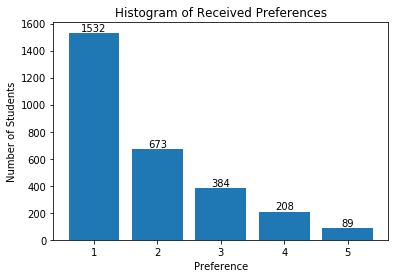

1 : 53.08 %
2 : 23.32 %
3 : 13.31 %
4 : 7.21 %
5 : 3.08 %


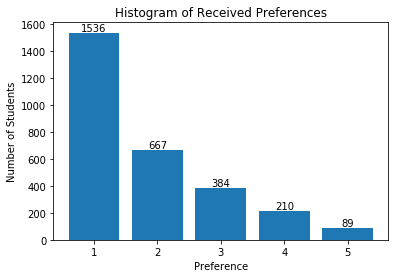

1 : 53.22 %
2 : 23.11 %
3 : 13.31 %
4 : 7.28 %
5 : 3.08 %


In [10]:
from fws_lab_ext import Histo

# Assign function solution
Histo(data_sol, 15)

for pref in range(1,6):
    print(pref, ":", round(100*data_sol[pref]/2886, 2), "%")

    
# Modified Assign function solution
Histo(modified_sol, 15)

for pref in range(1,6):
    print(pref, ":", round(100*modified_sol[pref]/2886, 2), "%")

**Q13:** Compare the objective values of the two solutions (you can use the cell below for computations if you'd like). What do you observe? Is this surprising? (Remember we set the cost of a student receiving their $k$th preference to be $k$; that is, a student receiving their top choice cost 1, second choice cost 2, and so forth)

**A:** <font color='blue'>Even though the solutions are different, both should have cost 5307. It may not be surprising that we can't do better than the original, less-constrained model, but more significant is the fact that the min-class-size constraint doesn't worsen the objective value.</font>

In [11]:
### CELL FOR COMPUTATIONS ###


**Q14:** The Knight Institute is also interested in seeing the least amount of classes they can run, given the data on student preferences. To implement this, we can re-define the objective function in our model to the following:

<code>m.Minimize(sum(y[j] for j in CLASS))</code>

Doing this will give a solution with an objective value of 181. We claim that this is optimal, regardless of the minimum class size. Why? (Recall that there are 2886 students in total.)

**A:** <font color='blue'>The objective value essentially says that we can never run less than 181 class sections if we want a feasible solution. Suppose we fill each classroom to the max, that is, assign 16 students per class for as many classes as possible. We can fill $\frac{2886 - 2886\bmod16}{16} = 180$ classes this way, with a remaining $2886\bmod16 = 6$ students to put in the 181st class section. (With a maximum of 183 class sections available, there isn't much wiggle room!)</font>

We could extend the problem even further by aiming to satisfy the most students (by assigning them to their preferred classes) while running as few classes as possible. Clearly, there's a trade-off here: by running fewer classes, the university saves money, but might leave some students dissatisfied with their FWS assignment, and vice-versa. This is a peek into the messy world of *multi-objective optimization*! 

In this case, we know the minimum number of classes we can run will be 181, so we can just add a constraint to our model to enforce this while the objective function remains the same.

**Q15:** Write the constraint that our model must run exactly 181 classes, using the code from **Q14** as a guide. Your answer should look like this: m.Add(XXX)

**A:** <font color='blue'>m.Add(sum(y[j] for j in CLASS) == 181)</font>

# Part 3: New Objectives
*Adapted from previous versions of the FWS lab.* 

As you have probably noticed, the different models presented in this lab find different feasible solutions to the FWS assignment problem&mdash;that is, they find a matching of students to FWS sections that ensures every student gets one of their top 5 picks. Having many solutions is great, but in a real-life scenario, we can only pick one!

Once we know we have feasible solutions, deciding which of the solutions is "the best" depends on what our goal is. For instance, our goal could be to find the solution that maximizes the number of students receiving their first choice, or to minimize the number of students receiving their fifth choice.

It turns out we can achieve some complex behavior in our solutions by making some clever adjustments to our original objective function.

**Q16:** In our original input for the FWS assignment problem, we set the unit cost of edges from the dummy node to be 100,000. Why?

**A:** <font color='blue'>In the FWS lab, we discussed how the objective function is actually a weighted function. The coefficients, which in this case are the costs, dictate how much you want the solver to select the corresponding edges. An edge with a small cost has a higher likelihood (weight) of being in the solution while an edge with a large cost will potentially be avoided. This being said, we can try setting the cost of edges from the dummy node to an arbitrarily large number like 100,000. This should create greater incentive to fill classes with actual students than our fake filler 'students' as we witnessed in the second small example. [Taken directly from the FWS lab]
    
More technically, the cost of not assigning just *one* student to one of their top 5 choices is greater than the cost of assigning all 2886 students their fifth choice! Using this method thus ensures a maximal assignment of students to classes, if one exists, before considering student preferences.</font>

Let's use this notion of "weight adjustment" to see how it plays into the solutions we can find. Run the cell below, which defines a method to facilitate incorporating varied edge costs into our modifiedAssign model.

In [12]:
from fws_lab_ext import updated_edge_costs

def part3(prefcosts):
    # Get the updated edge : cost dictionary
    newedges = updated_edge_costs(edges,prefcosts)

    # Assign students based on these new edge costs
    test_sol = modifiedAssign(students, classes, newedges, 6, 16, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Format results
    new_costs_to_prefs = dict(zip(list(newedges.values())[:5],list(range(1,6))))

    prefs_to_nums = {}
    for key in test_sol.keys():
        prefs_to_nums[new_costs_to_prefs[key]] = test_sol[key]   
    
    # See histogram
    Histo(prefs_to_nums,15)
    
    for pref in range(1,6):
        print(pref, ":", round(100*prefs_to_nums[pref]/2886, 2), "%")

Going back to our example, let's find a solution that maximizes the number of students receiving their first choice. To do this, we need to somehow "entice" the solver into picking edges corresponding to students' first preference. This is just the opposite of what we did with the dummy node! 

In the cell below, we set the cost of edges between a student and their first-choice class to be an arbitrarily large *negative* number (-10,000). It's worth noting that edge costs can be positive or negative here, since we're not so much concerned about the actual cost of our solution as we are about the relationship between the costs of different types of edges.

Unmatched students: 0


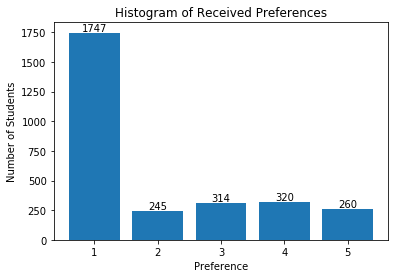

1 : 60.53 %
2 : 8.49 %
3 : 10.88 %
4 : 11.09 %
5 : 9.01 %


In [13]:
# Define new edge costs here
prefcosts = {1:-10000,
             2:2,
             3:3,
             4:4,
             5:5}

# Run the model with the new edge costs
part3(prefcosts)

Now, let's see a solution where the number of students receiving their fifth choice is minimized. In the cell below, modify the cost of edges from a student to their fifth-choice class to achieve this objective, then run it and see what you get! 

(As a sanity check, you should find that only 15 students receive their fifth choice.)

Unmatched students: 0


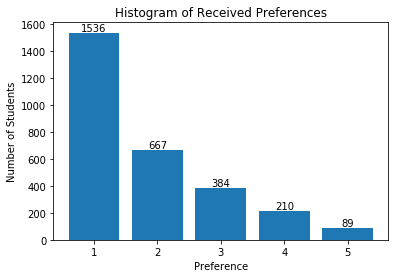

1 : 53.22 %
2 : 23.11 %
3 : 13.31 %
4 : 7.28 %
5 : 3.08 %


In [14]:
# Define new edge costs here
prefcosts = {1:1,
             2:2,
             3:3,
             4:4,
             5:5 # change this value
            }

# Run the model with the new edge costs
part3(prefcosts)

**Q17:** Compare these two solutions (maximizing first choice versus minimizing fifth choice). If you had to present one of these solutions to the FWS assignment committee, which would you present? Give a reason for your choice.

**A:** <font color='blue'>Answers may vary, but one justification for the second solution is that it is monotonically decreasing, i.e, the number of students receiving their first choice is greater than the number of students receiving their second choice, which is greater than the number of students receiving their third choice, etc. Additionally, the second solution has a lesser (meaning better) mean preference received.</font>

What if we wanted to combine these approaches? For example, we could first maximize the number of students receiving their first preference, then maximize the number of students receiving their second preference, and so on. Or, we could first minimize the number of students receiving their fifth choice, then minimize the number of students receiving their fourth choice, etc. In both cases, there exists a notion of "ranking" or "prioritizing" different objectives.

How can we encode a ranking of importance among our different objectives? We'll use weights of different orders of magnitude.

For example, suppose we have two objective functions, $f_{1}$ and $f_{2}$. We'd like to first minimize $f_{1}$, and then minimize $f_{2}$. If we were to write out an expression such as $min\:f_{1} + f_{2}$, then decreasing either $f_{1}$ or $f_{2}$ by some amount $\delta$ would have the same effect; in essence, $f_{1}$ and $f_{2}$ have "equal priority."

However, if instead we write $min\:10f_{1} + f_{2}$, then decreasing $f_{1}$ by $\delta$ has 10 times the effect on lowering the cost of the solution as decreasing $f_{2}$ by the same amount&mdash;so minimizing $f_{1}$ has "greater priority" than minimizing $f_{2}$. 

We can apply similar reasoning to our problem; in fact, we already have! Take another look at our objective function:

$min\:\sum_{(i,j) \in A} c(i,j)x(i,j) = min\:\sum_{k=1}^{5} ($edge cost of preference $k)($number of students assigned preference $k)$<br>$= min\:c_1 f_{1} + c_2 f_{2} + c_3 f_{3} + c_4 f_{4} + c_5 f_{5}$

Our costs $c_k$ for each edge type $k$, enumerated in <code>prefcosts</code>, specify the "weights" (or "priorities") of each function $f_k$ in our overall objective function. For instance, specifying costs $c_k = k, k \in \{1,..,5\}$, prioritizes minimizing $f_{5}$ before minimizing $f_{1}$. 

Let's utilize this knowledge to implement the second approach outlined above.

Run the following cell, which uses weights of different orders of magnitude to effectively "rank" our objectives in order of importance: first (most importantly), we minimize the number of fifth preferences assigned, second (most importantly), we minimize the number of fourth preferences assigned, and so forth until our least important objective, minimizing the number of first preferences.

Unmatched students: 0


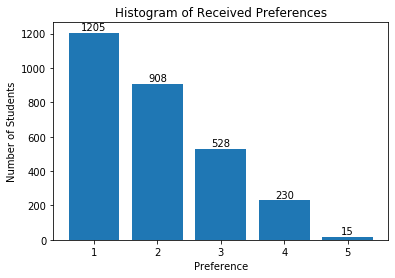

1 : 41.75 %
2 : 31.46 %
3 : 18.3 %
4 : 7.97 %
5 : 0.52 %


In [15]:
# Define new edge costs here
prefcosts = {1:0,
             2:10,
             3:100,
             4:1000,
             5:10000}

# Run the model with the new edge costs
part3(prefcosts)

As we've seen, there are a plethora of solutions to the FWS assignment problem! Choosing just one depends on how you define the "best" solution. 

The Knight Institute decided on the following criteria in determining the optimal solution:<br>
First, the number of fifth, and then fourth, preferences should be minimized.<br>
After that, the number of first, second, and then third preferences should be maximized.

Below, try to implement these specifications, using weights with different orders of magnitude for each successive objective. (Hint: minimizing a negative expression is the same as maximizing that expression!)

Unmatched students: 0


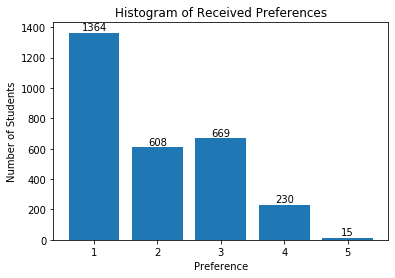

1 : 47.26 %
2 : 21.07 %
3 : 23.18 %
4 : 7.97 %
5 : 0.52 %


In [16]:
# TODO: Fill in the missing edge costs to achieve the desired objectives
# prefcosts = {1:XXX, 2:XXX, 3:0, 4:XXX, 5:10000}

### BEGIN SOLUTION
prefcosts = {1:-100, 2:-10, 3:0, 4:1000, 5:10000}
### END SOLUTION

# Run the model with the new edge costs
part3(prefcosts)

**Q22:** Compare this solution to the previous solutions. Do you think the Knight Institute made the right decision? How would you have done it differently?

**A:** <font color='blue'>Answers may vary.</font>

# Messing with Integrality (TESTING)

In [17]:
# A modified FWS assignment model, which incorporates minimum class size and the option of not running class sections

# INPUTS:
# students: a list of students
# classes: a list of classes
# edges: a dictionary of edge costs
# minstudents: minimum number of students per class section
# csize: maximum number of students per class section
# solver: the solver to be used
# integer: Boolean value, whether or not decision variables are constrained to integer values (default: True)
def integralityAssign(students, classes, edges, minstudents, csize, solver, integer=True):
    STUDENT = students              # create student list
    CLASS = classes                 # create class list
    EDGES = list(edges.keys())      # create edge list    
    
    c = edges.copy()                # define c[i,j]
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # decision variables
    x = {}    
    for i,j in EDGES:
        # define x(i,j) here
        if integer:
            x[i,j] = m.IntVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
        else:
            x[i,j] = m.NumVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
            
    y = {}
    for j in CLASS:
        # define y_j here
        y[j] = m.BoolVar('y_%s' % j) # A BoolVar or Boolean variable is similar to an integer variable,
                                     # except that it can only take on values in {0,1}, where 0 represents "false"
                                     # and 1 represents "true." We could have also used an IntVar ranging from 0 to 1.
               
    # define objective function here
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
       
    # add constraint to ensure each student is assigned exactly one class
    for k in students:
        m.Add(sum(x[i,j] for i,j in EDGES if i==k) == 1)
        
    # add constraint to ensure each class that runs satisfies minimum and maximum class size
    for k in classes:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) <= csize*y[k])
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) >= minstudents*y[k])
    
    # solve
    status = m.Solve()
    
    if status == OR.Solver.INFEASIBLE:
        print('Infeasible')
        return
 
    # test for non-integer values
    for i,j in EDGES:
        if x[i,j].solution_value() > 0.0 and x[i,j].solution_value() < 1.0:
            print(x[i,j].solution_value())
            
    unmatched = []
    for k in STUDENT:
        if (sum(x[i,j].solution_value() for i,j in EDGES if i==k) == 0):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in EDGES:
        if x[i,j].solution_value() == 1:
            if c[i,j] in matched:
                matched[c[i,j]] += 1
            else:
                matched.update({c[i,j] : 1})
    
    return matched

def part4(prefcosts,integral):
    # Get the updated edge : cost dictionary
    newedges = updated_edge_costs(edges,prefcosts)

    # Assign students based on these new edge costs
    test_sol = integralityAssign(students, classes, newedges, 6, 16, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING,integer=integral)

    # Format results
    new_costs_to_prefs = dict(zip(list(newedges.values())[:5],list(range(1,6))))

    prefs_to_nums = {}
    for key in test_sol.keys():
        prefs_to_nums[new_costs_to_prefs[key]] = test_sol[key]   
    
    # Print results
    print('Preferences received:')
    for i in sorted(prefs_to_nums):
        print('%1s: %1s' % (i,prefs_to_nums[i]))      

In [18]:
#prefcosts = {1:1, 2:2, 3:3, 4:4, 5:5}
prefcosts = {1:-0.453, 2:2.568, 3:3.997, 4:4.120, 5:5.04}
part4(prefcosts,False)


Unmatched students: 0
Preferences received:
1: 1665
2: 425
3: 256
4: 293
5: 168
